# Trees and Gradient Boosting (Daniel Pak and Harry Wei)
 

## XGB regression on California Housing Dataset
- California Housing dataset by Pace and Barry (1997) is used in this analysis. We imported the data through scikitlearn.dataset.fetch_california_housing()
- An XGB regression tree model is trained to predict the median house value in each neighbourhood. We also report relative weights of the model, indicating that MedInc is indeed the most important feature. The feature importance bar graph corresponds to figure 10.14 in Elements of Statistical Learning by Jerome H. Friedman et al. 
- We plot absolute error vs Iterations plot as a indicator of XGB algorithm's inner working principle. We also present Partial dependence of each important feature. This graph corresponds to figure 10.13.

In [ ]:
import requests
import zipfile
from urllib.request import urlopen
from io import BytesIO
from xgboost import XGBRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_california_housing
from time import time
from mpl_toolkits.mplot3d import Axes3D

"""
		Bols	tols
INTERCEPT		11.4939	275.7518
MEDIAN INCOME		0.4790	45.7768
MEDIAN INCOME2		-0.0166	-9.4841
MEDIAN INCOME3		-0.0002	-1.9157
ln(MEDIAN AGE)		0.1570	33.6123
ln(TOTAL ROOMS/ POPULATION)	-0.8582	-56.1280
ln(BEDROOMS/ POPULATION)	0.8043	38.0685
ln(POPULATION/ HOUSEHOLDS)	-0.4077	-20.8762
ln(HOUSEHOLDS)		0.0477	13.0792
"""

#source to import multiple files from online zip file: https://github.com/zooniverse/planet-four/issues/185
# df_cols = ["median house value", "median income", "housing median age", "total rooms", "total bedrooms", "population", "households", "latitude", "longitude"]
# zip_file_url = "http://lib.stat.cmu.edu/datasets/houses.zip"
# remote_zip_file = urlopen(zip_file_url)
# zipinmemory = BytesIO(remote_zip_file.read())
# zip_file = zipfile.ZipFile(zipinmemory)

cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target
y -= y.mean()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
display(X_test.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43


### XGB regressor training and evaluation
In this block we train a extreme gradient boosted tree regressor using the XGBRegressor from xgboost library. Number of estimators = 800 to replicate the analysis in textbook, and squarederror loss function is used. Maximum depth of the tree is set to be 6 to prevent overfitting, and learning rate specified to be 0.1. Classification error for each iteration is calculated based on MAE (mean absolute error).

The two output graphs resonates the textbook figures (10.14 and 10.13). The test error rate could not drop below certain threshold, while training error rate declines continuously. The feature importances also correspondes to those in the textbook.

Mean Absolute Error Predicting the Test Set = 0.2927

Baseline Mean Absolute Error of the Test Set = 0.9033



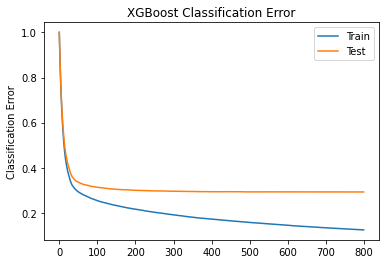

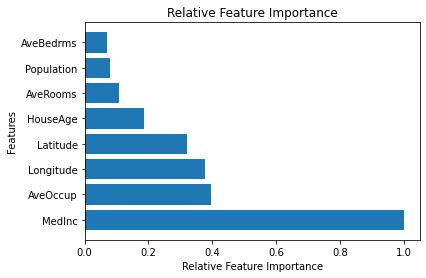

In [ ]:
##############################################################
# fit model no training data
model = XGBRegressor(n_estimators = 800,objective='reg:squarederror',max_depth = 6, learning_rate= 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
metric = 'mae'
model.fit(X_train, y_train, eval_metric=[metric], eval_set=eval_set, verbose=0)
# make predictions for test data
y_pred = model.predict(X_test)

# evaluate predictions
mae = np.mean(abs(y_test-y_pred))
print(f"Mean Absolute Error Predicting the Test Set = {round(mae,4)}\n")

# Baseline MAE
mae_baseline = np.mean(abs(y_test-y_test.mean()))
print(f"Baseline Mean Absolute Error of the Test Set = {round(mae_baseline,4)}\n")

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0'][metric])
x_axis = range(0, epochs)
feature_names = X_train.columns
rel_importance = model.feature_importances_ / max(model.feature_importances_ )
sorted_idx = np.flip(rel_importance.argsort())

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0'][metric], label='Train')
ax.plot(x_axis, results['validation_1'][metric], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

# Plot Relative Feature Importance
plt.figure()
plt.title("Relative Feature Importance")
plt.xlabel("Relative Feature Importance")
plt.ylabel("Features")
plt.barh(feature_names[sorted_idx], rel_importance[sorted_idx])
plt.show()

### Partial Dependence Plots of Select Features
This block replicates Figure 10.15 of the textbook. Partial dependence of Median Income, Average Occupency, House Age and Average number of rooms are plotted.


Computing partial dependence plots...
done in 175.975s


<Figure size 720x720 with 0 Axes>

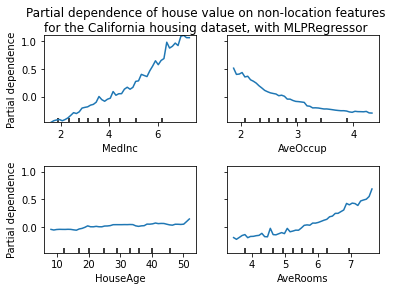

In [ ]:
# Partial Dependency
# Plots Partial Denpendency of specified features. Code from Scikit learn documentation, linked below
# https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#partial-dependence-computation-for-gradient-boosting
fig = plt.figure(figsize=[10,10])
tic = time()
print('Computing partial dependence plots...')
# We don't compute the 2-way PDP (5, 1) here, because it is a lot slower with the brute method.
features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']
plot_partial_dependence(model, X_train, features, n_jobs=3,grid_resolution=50,n_cols=2)
print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the California housing dataset, with MLPRegressor')
fig.subplots_adjust(hspace=0.5)

### Summary of Results for California Housing

For the California Housing dataset, we replicated the analysis as mentioned in the textbook. We used 800 as iterations, 0.1 for our learning rate, and 6 as our max depth. Our objective function was mean squared. Using XGBoost, our mean absolute error is 0.2927, with a baseline of 0.9033. The textbook reported an error of 0.31. 

The most relevant predictor is Median Income, with the least relavent being Average Bedrooms. Using our partial dependence plot, it's shown that Median Income, Average Rooms, and Average Occupancy have a dependence to house value. 

## Chosen Dataset
We chose [MAGIC Gamma Telescope Data Set](https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) from UCI to train a classification tree using XGboost, and plot partial depence, as well as relative feature importance. The label "class" was chosen such that g (gamma - signal) is 1 and h (hadron - background) is 0.

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split

"""
    1.  fLength:  continuous  # major axis of ellipse [mm]
    2.  fWidth:   continuous  # minor axis of ellipse [mm] 
    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
   10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
   11.  class:    g,h         # gamma (signal), hadron (background)
"""

df_col_gamma = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class" ]
df_g = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data",names=df_col_gamma)
df_plot_g = df_g.copy()
classification = {"g": 1,"h": 0}
df_g["class"] = df_g["class"].map(classification) #changes "class" label into binary

Y_g = df_g.pop("class")

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(df_g, Y_g, test_size=0.2, random_state=7)
display(X_train_g.head())
display(y_train_g.head())

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
7026,26.4006,13.2825,2.6508,0.5296,0.2849,18.8617,22.3633,9.7745,31.1550,125.2660
16290,81.0903,37.7359,3.4873,0.1521,0.0926,-96.9642,63.0869,18.4721,3.6095,264.4950
1755,19.1072,12.2813,2.4691,0.5840,0.3379,-17.1689,-14.6245,-6.6801,3.6579,170.5160
13938,41.8730,11.8226,2.6465,0.4711,0.2454,-25.5295,-62.5390,-7.1176,76.8503,234.0699
18511,91.2356,24.8769,2.6258,0.4402,0.2497,-39.2618,-95.4027,-14.1885,13.5704,169.3060


7026     1
16290    0
1755     1
13938    0
18511    0
Name: class, dtype: int64

### Data Distribution: The Dataset is Not Clearly Distinguishable
The scatter matrix below is used to show hpw messy the selected dataset is. The MAGIC Gamma Telescope dataset contains 19020 samples and 10 features and a  binary label. There is no clear way to differentiate between g and h for the non diagonal entries as there are no exclusive groupings.

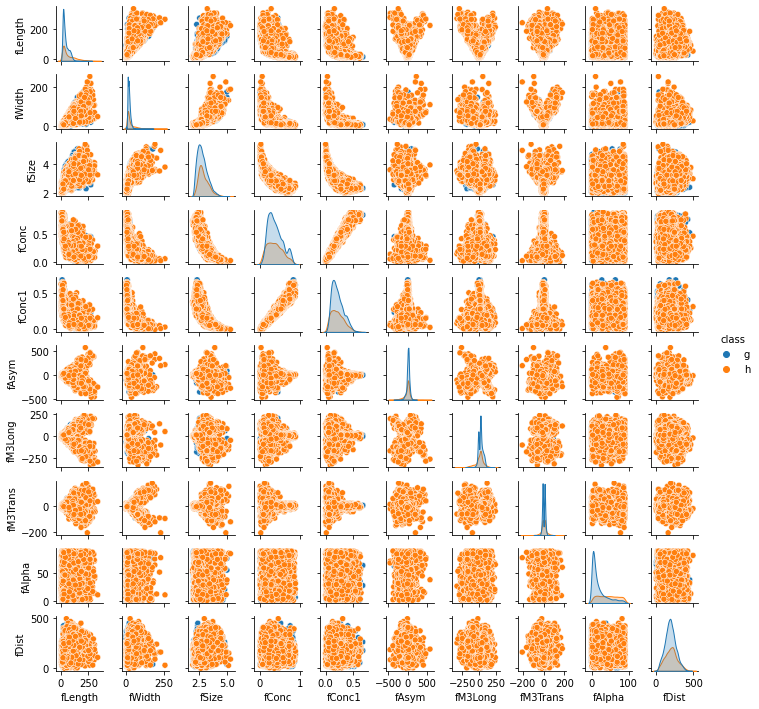

In [ ]:
seaborn.pairplot(df_plot_g, hue = "class", kind='scatter', diag_kind='kde', height=1, 
                 aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)


### Tuning Our Model to Optimize Performance

The max accuracy occurs with n_estimators = 1000


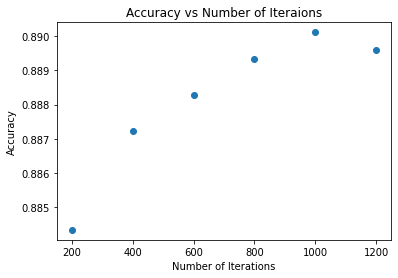

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

"""
Determining Number of Estimators
"""
scores = []
number_loops = np.arange(200,1400,200)
for i in number_loops:
  model = XGBClassifier(n_estimators = i,objective='reg:logistic',max_depth = 5, learning_rate= 0.1)
  eval_set = [(X_train_g, y_train_g), (X_test_g, y_test_g)]

  metric = "mae"
  model.fit(X_train_g, y_train_g, eval_metric=metric, eval_set=eval_set, verbose=False)
  # make predictions for test data
  y_pred = model.predict(X_test_g)
  predictions = [round(value) for value in y_pred]
  # evaluate predictions
  accuracy = accuracy_score(y_test_g, predictions)
  # print("Accuracy: %.2f%%" % (accuracy * 100.0))
  scores.append(accuracy)

plt.figure()
plt.scatter(number_loops,scores)
plt.title("Accuracy vs Number of Iteraions")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")

print(f"The max accuracy occurs with n_estimators = {number_loops[np.argmax(scores)]}")

The max accuracy occurs with max_depth = 14


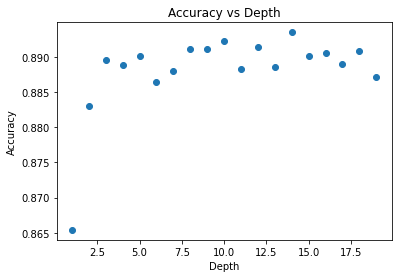

In [ ]:
"""
Determining Max Depth
"""
scores = []
depth_arr = np.arange(1,20,1)
for i in depth_arr:
  model = XGBClassifier(n_estimators = 1000,objective='reg:logistic',max_depth = i, learning_rate= 0.1)
  eval_set = [(X_train_g, y_train_g), (X_test_g, y_test_g)]

  metric = "mae"
  model.fit(X_train_g, y_train_g, eval_metric=metric, eval_set=eval_set, verbose=False)
  # make predictions for test data
  y_pred = model.predict(X_test_g)
  predictions = [round(value) for value in y_pred]
  # evaluate predictions
  accuracy = accuracy_score(y_test_g, predictions)
  # print("Accuracy: %.2f%%" % (accuracy * 100.0))
  scores.append(accuracy)

plt.figure()
plt.scatter(depth_arr,scores)
plt.title("Accuracy vs Depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")

print(f"The max accuracy occurs with max_depth = {depth_arr[np.argmax(scores)]}")

The max accuracy occurs with learning_rate = 0.1


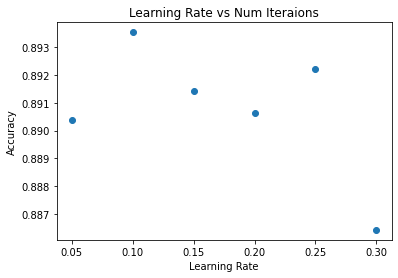

In [ ]:
"""
Determining Learning Rate
"""
scores = []
learning_array = np.arange(0.05,0.35,0.05)
for i in learning_array:
  model = XGBClassifier(n_estimators = 1000,objective='reg:logistic',max_depth = 14, learning_rate=i)
  eval_set = [(X_train_g, y_train_g), (X_test_g, y_test_g)]

  metric = "mae"
  model.fit(X_train_g, y_train_g, eval_metric=metric, eval_set=eval_set, verbose=False)
  # make predictions for test data
  y_pred = model.predict(X_test_g)
  predictions = [round(value) for value in y_pred]
  # evaluate predictions
  accuracy = accuracy_score(y_test_g, predictions)
  # print("Accuracy: %.2f%%" % (accuracy * 100.0))
  scores.append(accuracy)
plt.figure()
plt.scatter(learning_array,scores)
plt.title("Learning Rate vs Num Iteraions")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")

print(f"The max accuracy occurs with learning_rate = {learning_array[np.argmax(scores)]}")

### XGBoost Classification
In this section, we train a XGBoost classifier on the Magic Telescope dataset, and generates similar error vs iterations plot, and relative feature importance bar graph. The previous section was used to determine the optimal parameters, which was then implemented here.

Accuracy: 89.35%
Baseline is 65.0%


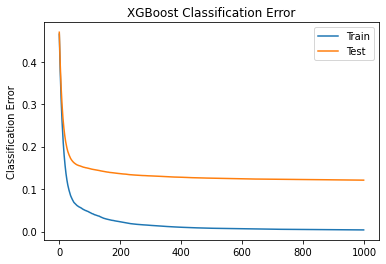

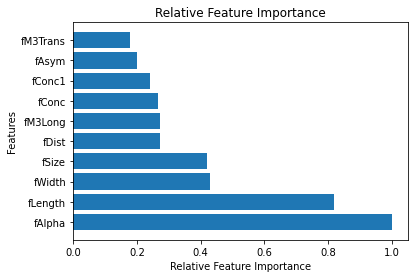

In [ ]:
model = XGBClassifier(n_estimators = 1000,objective='reg:logistic',max_depth = 14, learning_rate= 0.1)
eval_set = [(X_train_g, y_train_g), (X_test_g, y_test_g)]
metric = "mae"
model.fit(X_train_g, y_train_g, eval_metric=metric, eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = model.predict(X_test_g)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test_g, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(f"Baseline is {round(y_test_g.mean(),2)*100}%")
results = model.evals_result()
epochs = len(results['validation_0'][metric])
x_axis = range(0, epochs)
feature_names = X_train_g.columns
rel_importance = model.feature_importances_ / max(model.feature_importances_ )
sorted_idx = np.flip(rel_importance.argsort())

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0'][metric], label='Train')
ax.plot(x_axis, results['validation_1'][metric], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

# Plot Relative Feature Importance
plt.figure()
plt.title("Relative Feature Importance")
plt.xlabel("Relative Feature Importance")
plt.ylabel("Features")
plt.barh(feature_names[sorted_idx], rel_importance[sorted_idx])
plt.show()

### Partial Dependence Plots of Features

Computing partial dependence plots...


<Figure size 2880x2880 with 0 Axes>

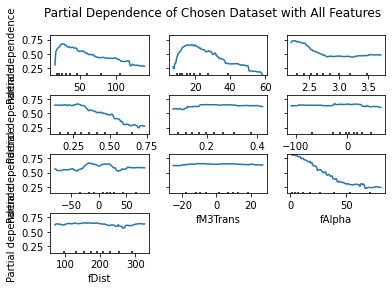

In [ ]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize=[40,40])
print('Computing partial dependence plots...')
df_col_gamma = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist"]
# We don't compute the 2-way PDP (5, 1) here, because it is a lot slower with the brute method.
plot_partial_dependence(model, X_train_g, df_col_gamma, n_jobs=-1,grid_resolution=100,n_cols=3)
fig = plt.gcf()
fig.suptitle('Partial Dependence of Chosen Dataset with All Features')
fig.subplots_adjust(hspace=0.5)

### Summary of Results for Chosen Dataset


For our chosen MAGIC Telescope dataset, we performed the same procedure as the California Housing dataset, albeit this is now a binary classification. 

Compared to the book which gave the parameters, we were tasked with tuning our chosen dataset's parameters. We chose to tune n_estimators, max_depth, and learning_rate. Our method of doing so was by seeing how the accuracy changes given a change in a single parameter with all others held constant, on the test set. We determined that our model performs the best when n_estimators = 1000, max_depth = 14, and learning_rate = 0.1. We kept the objective function as "binary:logistic" at all times. Our accuracy is 89.35% compared to a baseline of 65.0%.

The most relavent feature was falpha in all cases of testing, with fm3Trans being the lowest. Looking at our Partial Dependence Plot, fAlpha does have a linear relationship with whether it's gamma or hadron. 

## Stretch Goal #2: Implement Gradient Boosting
We use a simple tree method (scikit DecisionTreeRegressor) and implement algorithm 10.3 (Gradient Boosting Algorithm). We tune the algorithm and test it on the California Housing dataset, and compare the model prediction agaist a baseline.

### Algorithm 10.3 Implementation with Sci-kit DecisionTreeClassifier
We followed [this video lecture from stats quest](https://www.youtube.com/watch?v=3CC4N4z3GJc) to implement this algorithm.
```
  # Psuedo Code:
  def GB(n_est,layers,rate,x_train,y_train):
    model = [] #list of trees
    intercept = y_train.mean()
    psuedo_residual = y_train.copy()-intercept
    for i = 1:n_est:
        cur_tree = tree.fit(x_train,psuedo_residual)
        psuedo_residual -= rate * cur_tree.predict(x_train)
        model.append(cur_tree)
    return model
```

In [ ]:
def gradient_boosting(x_train,y_train,n_estimators,learning_rate,max_depth):
  """
  n_estimators = number of trees
  learning_rate = step size
  max_depth = layers of leaves
  criterion = "gini" or "entropy" depending on what you want
  """
  if n_estimators < 1:
    raise ValueError("n_estimators should be greater than or equal to 1")

  list_of_trees = []
  intercept = y_train.mean()
  psuedo_residual = y_train.copy() - intercept.copy()

  for i in range(n_estimators):
    cur_tree = DecisionTreeRegressor(criterion="mse",max_depth=max_depth)
    cur_tree.fit(x_train,psuedo_residual)
    psuedo_residual += learning_rate*cur_tree.predict(x_train)
    list_of_trees.append(cur_tree)

  model = {"list_of_trees":list_of_trees,"intercept":intercept,"learning rate":learning_rate}
  return model

def predict(X_test,model):
  prediction = model["intercept"]
  list_of_trees = model["list_of_trees"]
  learning_rate = model["learning rate"]
  for i in range(len(list_of_trees)):
    prediction += learning_rate* list_of_trees[i].predict(X_test)
  return prediction

### Gradient Boosting and parameter selection on california housing dataset

Decision trees have decreased accuracy when n_estimators becomes too big, a direct effect of overfitting. This segment of code shows this reduced accuracy effect by showing a rising MSE with increasing number of iterations.

We then select the best model parameters using a exhaustive search similar to GridSearchCV function. The exhaustive search every combination within the list of parameters specified, and selects the "Best model" with some criteria, in this case minumum MSE. It turns out the exhaustive search selected also 61 estimators and 0.01 learning rate again. Our initial guess was pretty close.

Optimumu n_estimators = 61, minimum MSE = 0.55
Best n_estimator = 70, best learning_rate = 0.01. 

minimum MSE = 0.541


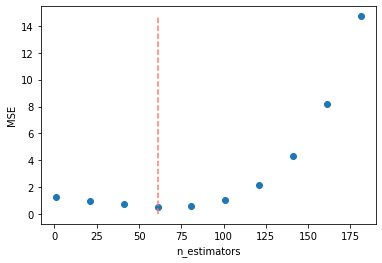

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from time import time

cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target
y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

estimator = np.arange(1,200,20).flatten()

mse = []
for i in estimator:
    model = gradient_boosting(X_train,y_train,i,0.01,5)
    y_pred = predict(X_test,model)
    mse.append(mean_squared_error(y_test,y_pred))

best_n_est = estimator[np.argmin(mse)]

plt.figure()
plt.scatter(estimator,mse)
plt.vlines(x=estimator[np.argmin(mse)],ymin = 0,ymax = max(mse), colors='#FA8072',linestyles='--')
plt.xlabel("n_estimators")
plt.ylabel("MSE")
print(f"Optimumu n_estimators = {best_n_est}, minimum MSE = {round(min(mse),3)}")


# Exhaustive Parameter search
rate = np.arange(0.01,0.5,0.1).flatten()
estimator = np.arange(50,200,20).flatten()

mse = []
best_est = 0
best_rate = 0
min_mse = 10000

for i in estimator:
  for j in rate:
    model = gradient_boosting(X_train,y_train,i,j,5)
    y_pred = predict(X_test,model)
    mse.append(mean_squared_error(y_test,y_pred))
    if (mse[-1]==min(mse)):
      best_est = i
      best_rate = j

print(f"Best n_estimator = {best_est}, best learning_rate = {best_rate}. \n")
print(f"minimum MSE = {round(min(mse),3)}")